# How Zipfian Was My Baby?

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

## Read data and group by year and gender

In [3]:
df = pd.read_csv("resources/NationalNames.csv")
gb = df.groupby(['Year','Gender'], sort=False)

In [4]:
df.loc[:,'Freq_yearly'] = gb['Count'].transform(lambda x: 100. * x / x.sum())
df.loc[:,'Cum_freq_yearly'] = gb['Freq_yearly'].cumsum()

df.loc[:,'Rank_yearly'] = gb['Count'].rank(ascending=False)

df.loc[:,"Pct_yearly"] = gb['Id'].transform(lambda x: 100.0 / x.count())
df.loc[:,"Cum_pct_yearly"] = gb['Pct_yearly'].cumsum()

In [300]:
men = df.loc[df.Gender=="M",:]

all_time_rank = men.groupby(['Name'])[['Freq_yearly']].sum().rank(ascending=False).rename(columns={"Freq_yearly": "All_time_rank"})
all_time_rank.head()

,All_time_rank
Name,
Aaban,17244.0
Aabid,37569.5
Aadam,11625.0
Aadan,14723.0
Aadarsh,12814.0


In [304]:
top10 = all_time_rank.loc[all_time_rank.All_time_rank < 11, :]\
  .join(men.set_index("Name"), how="left")
top10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, Charles to William
Data columns (total 10 columns):
All_time_rank      1350 non-null float64
Id                 1350 non-null int64
Year               1350 non-null int64
Gender             1350 non-null object
Count              1350 non-null int64
Freq_yearly        1350 non-null float64
Cum_freq_yearly    1350 non-null float64
Rank_yearly        1350 non-null float64
Pct_yearly         1350 non-null float64
Cum_pct_yearly     1350 non-null float64
dtypes: float64(6), int64(3), object(1)
memory usage: 116.0+ KB


In [305]:
top10.head()

,All_time_rank,Id,Year,Gender,Count,Freq_yearly,Cum_freq_yearly,Rank_yearly,Pct_yearly,Cum_pct_yearly
Name,,,,,,,,,,
Charles,5.0,946,1880,M,5348,4.840213,27.569666,4.0,0.094518,0.378072
Charles,5.0,2943,1881,M,4636,4.601717,31.798104,5.0,0.100301,0.501505
Charles,5.0,4968,1882,M,5092,4.478925,30.814158,5.0,0.090992,0.454959
Charles,5.0,7120,1883,M,4826,4.612488,26.121821,4.0,0.097087,0.388350
Charles,5.0,9323,1884,M,4802,4.195902,29.482284,5.0,0.088889,0.444444


In [333]:
import json
import textwrap

records= [ {"key": i, "values": v} for i, v in 
          top10.apply(lambda row: [row.Year, row.Freq_yearly], axis=1)
          .groupby(level=0)\
          .aggregate(lambda ser: ser.tolist()).iteritems()
]

with open("./html/babyNameData.json", "w") as f:
  f.writelines(
    "\n".join(
      textwrap.wrap(
        json.dumps(records, sort_keys=True), 
        initial_indent=" ", 
        width=80
      )
      )
  )


In [332]:
f.writelines?

wrapper = textwrap.wrap(json.dumps(records),initial_indent=" ", width=80)

  f.write("[\n")
  max_ind = max(out.index)
  for i, row in out.iterrows():
    s = json.dumps({"key": row["keys"], "values": row["values"]}, sort_keys=True)
    
    endchar = "," if i != max_ind else ""
    f.write("\n".join(wrapper.wrap(s)) + endchar + "\n")
  f.write("\n]")

IndentationError: unexpected indent (<ipython-input-332-c3646561e2ab>, line 5)

## Compute the approximate Zipfian distribution

In [5]:
df.loc[:,'Zipf'] = gb['Rank_yearly'].transform(lambda x: 100. / (x * np.log(1.78 * x.count())))

In [77]:
def zipf_plotter(from_year, until_year=None, step=1, 
                 x='Rank_yearly', logx=True, 
                 y='Freq_yearly', logy=True,
                 gender="F",
                 ax=None):
  if ax is None:
    _, ax = plt.subplots(1, 1)
    
  if until_year is None:
    until_year = from_year + 1
    title = str(from_year)
  else:
    title = "%d - %d" % (from_year, until_year-1)
      
  years = range(from_year, until_year, step)
  for year in years:
    idx = np.logical_and(df.Year == year, df.Gender == gender)
    df.loc[idx, :].plot(kind="line", x=x, y=y, logx=logx, logy=logy, ax=ax)

  ax.set_title(title)
  ax.set_ylabel(y)
  
  for t, s in zip(ax.legend().get_texts(), years):
    t.set_text(s)
    
  return ax

### Compare Zipfian with actual

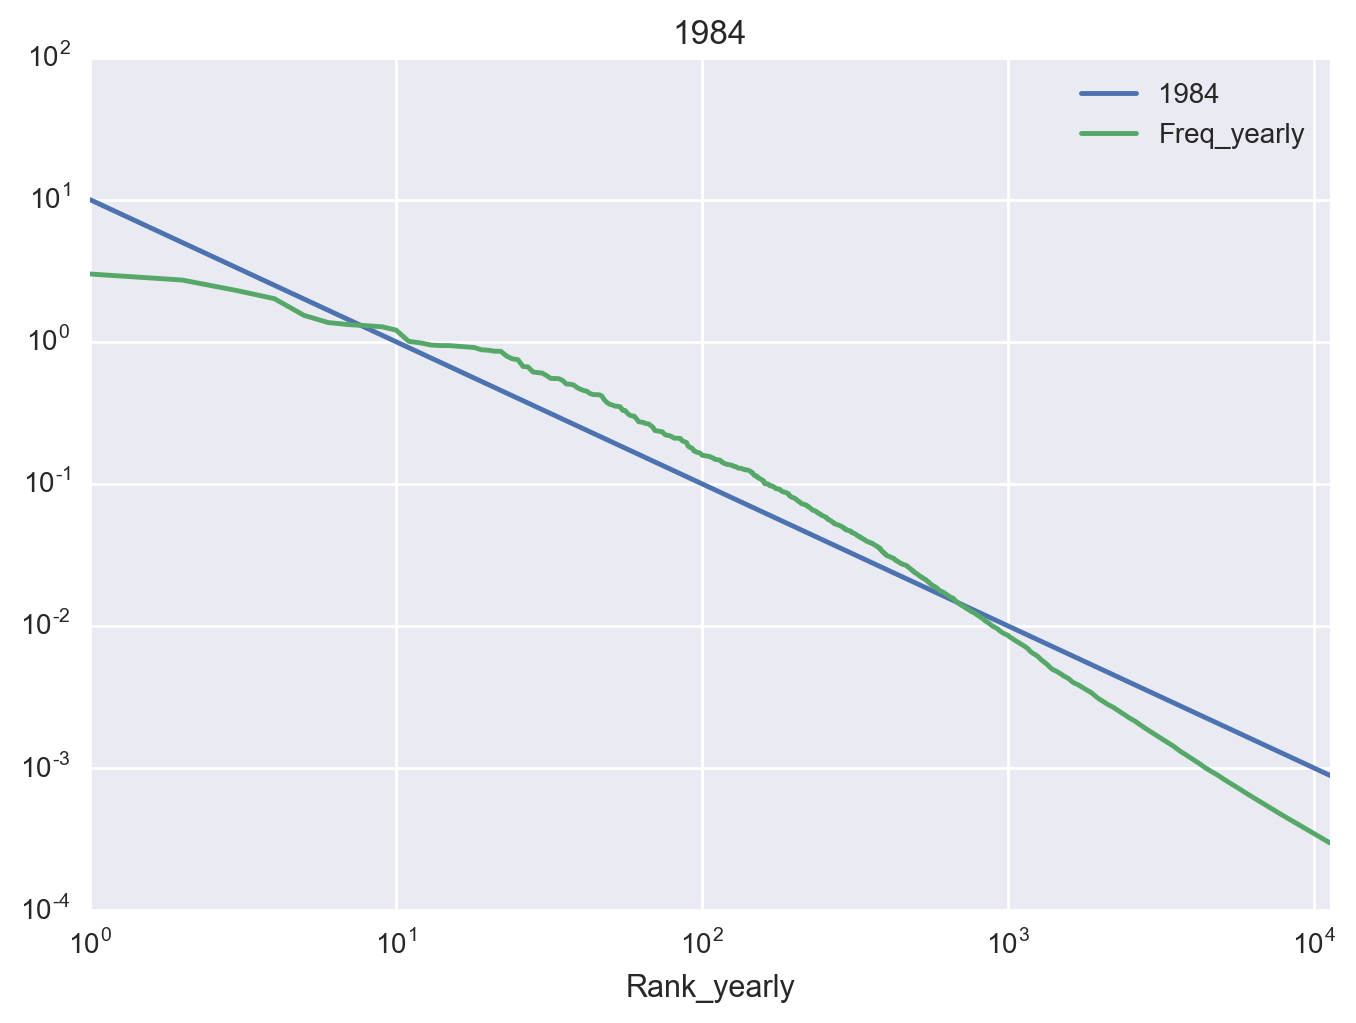

In [8]:
ax = zipf_plotter(1984,y='Zipf')
zipf_plotter(1984,y='Freq_yearly', ax=ax)

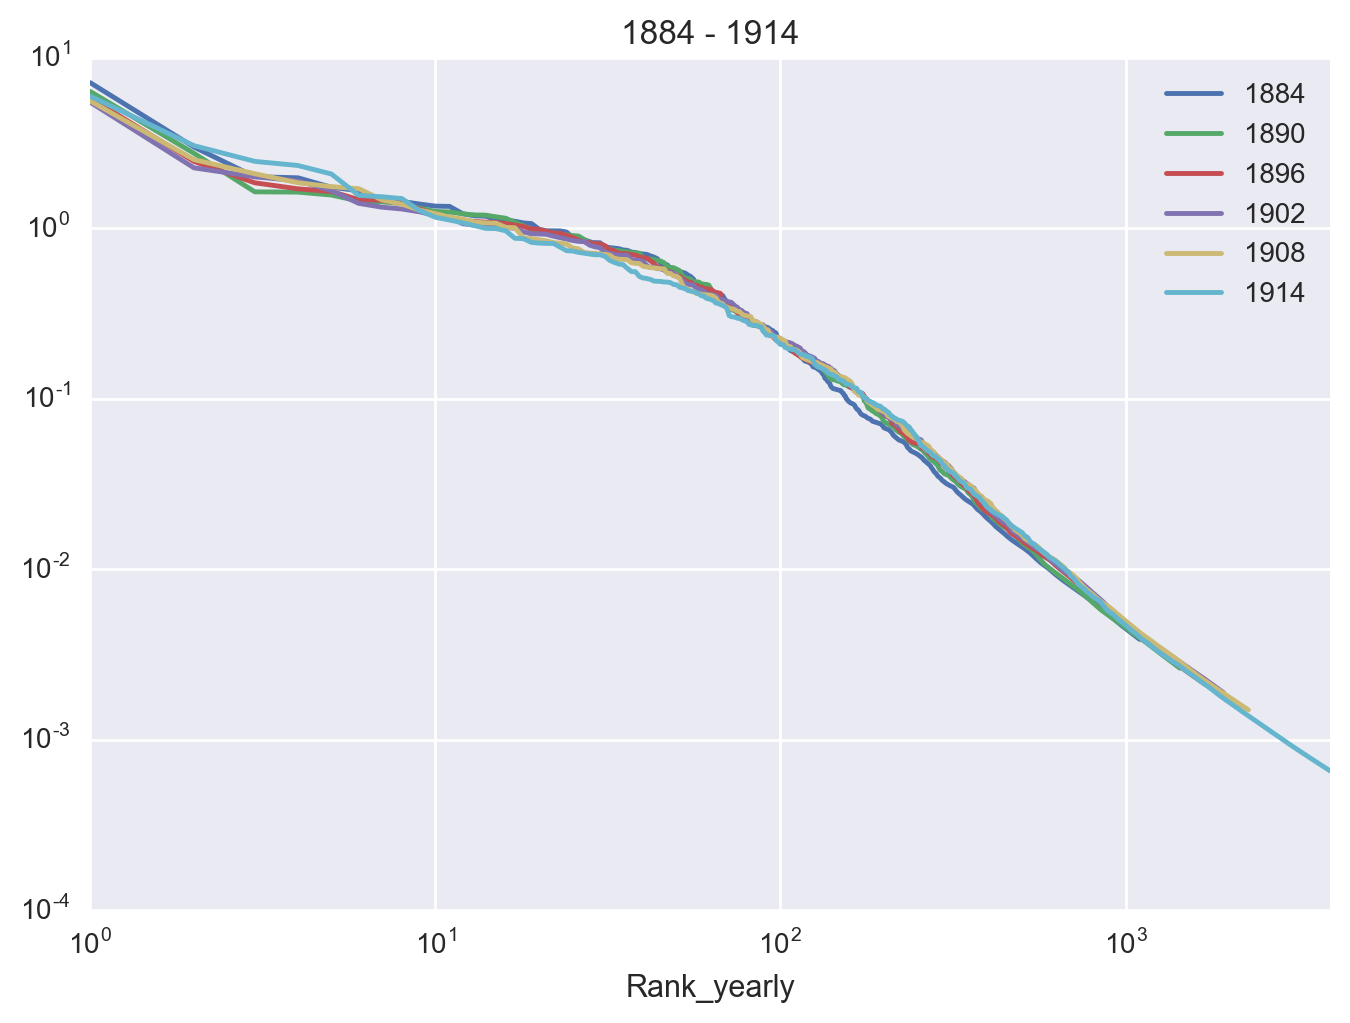

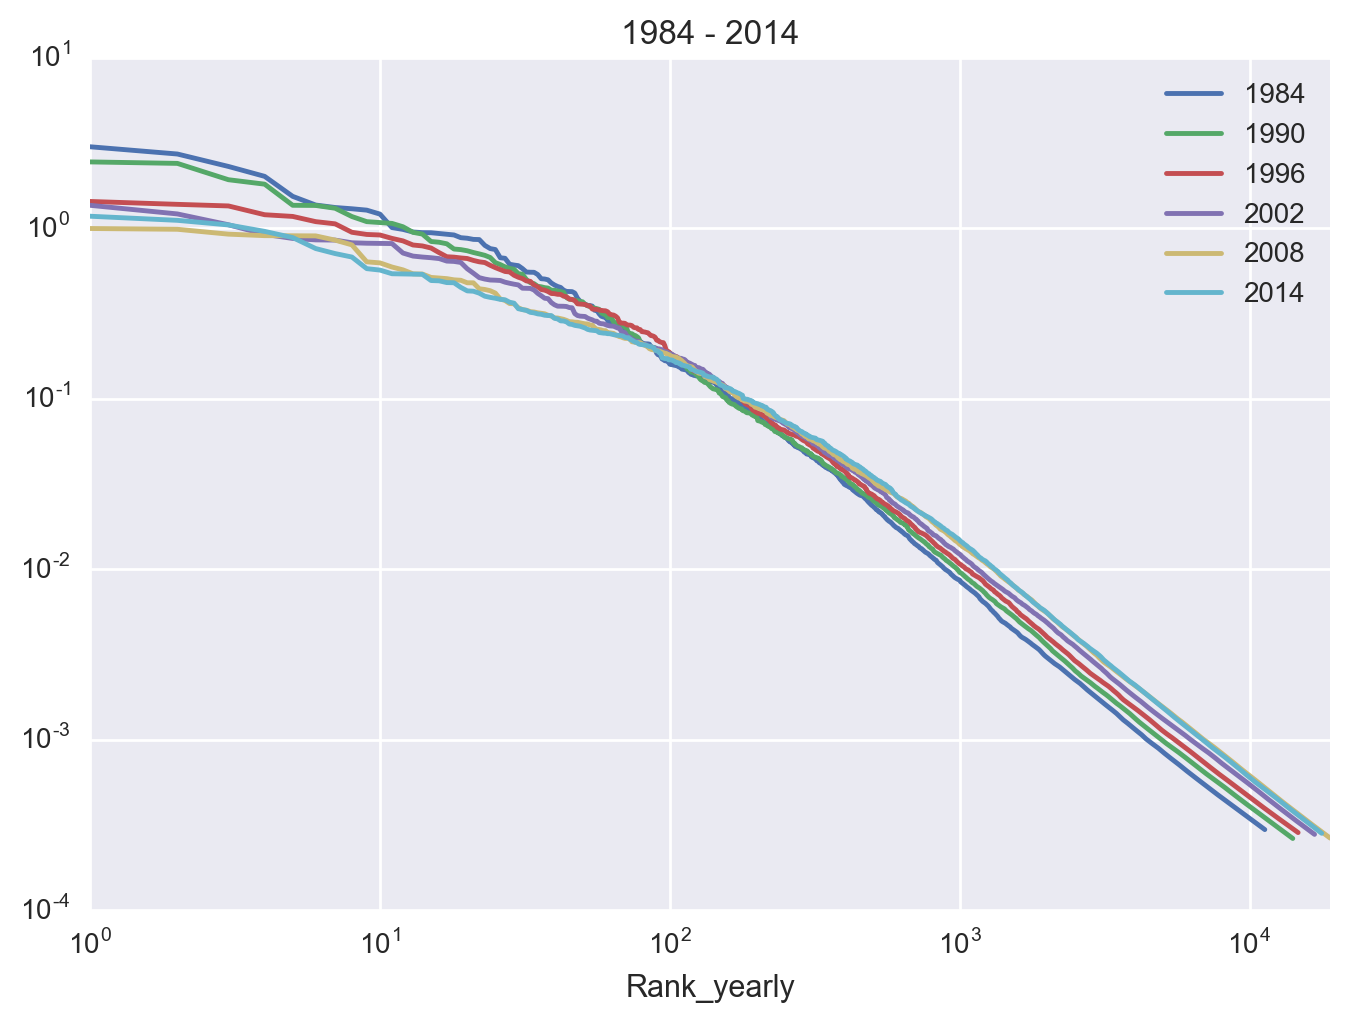

In [9]:
zipf_plotter(1884, 1915, 6)
zipf_plotter(1984, 2015, 6)

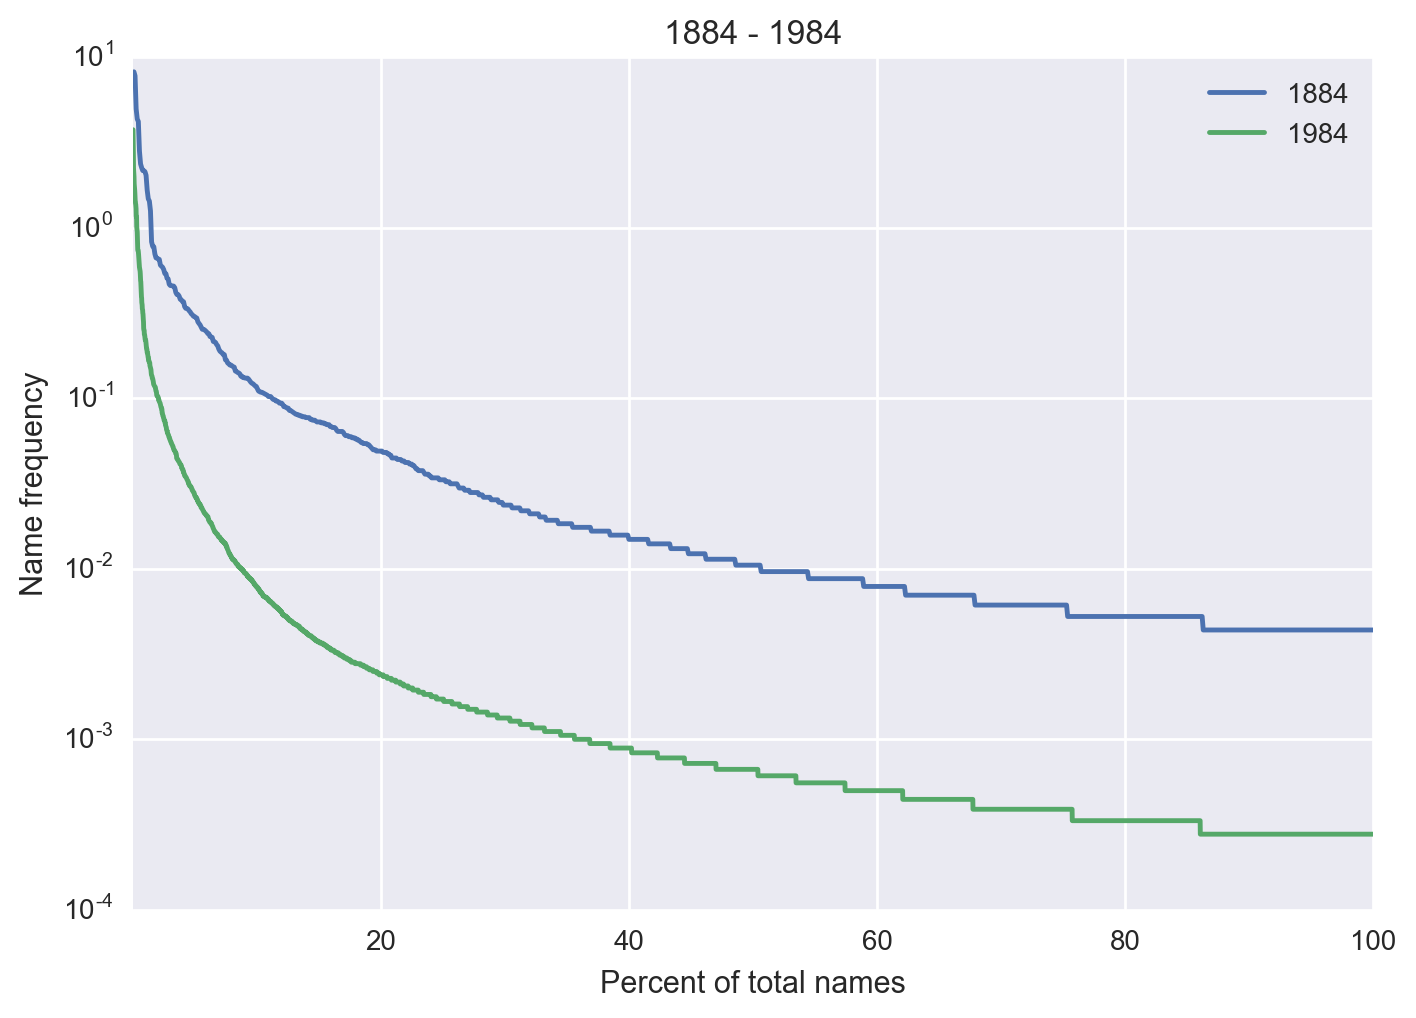

In [10]:
ax = zipf_plotter(1884, 1985, 100, x="Cum_pct_yearly", logx=False, gender="M")
ax.set_xlabel("Percent of total names")
ax.set_ylabel("Name frequency")

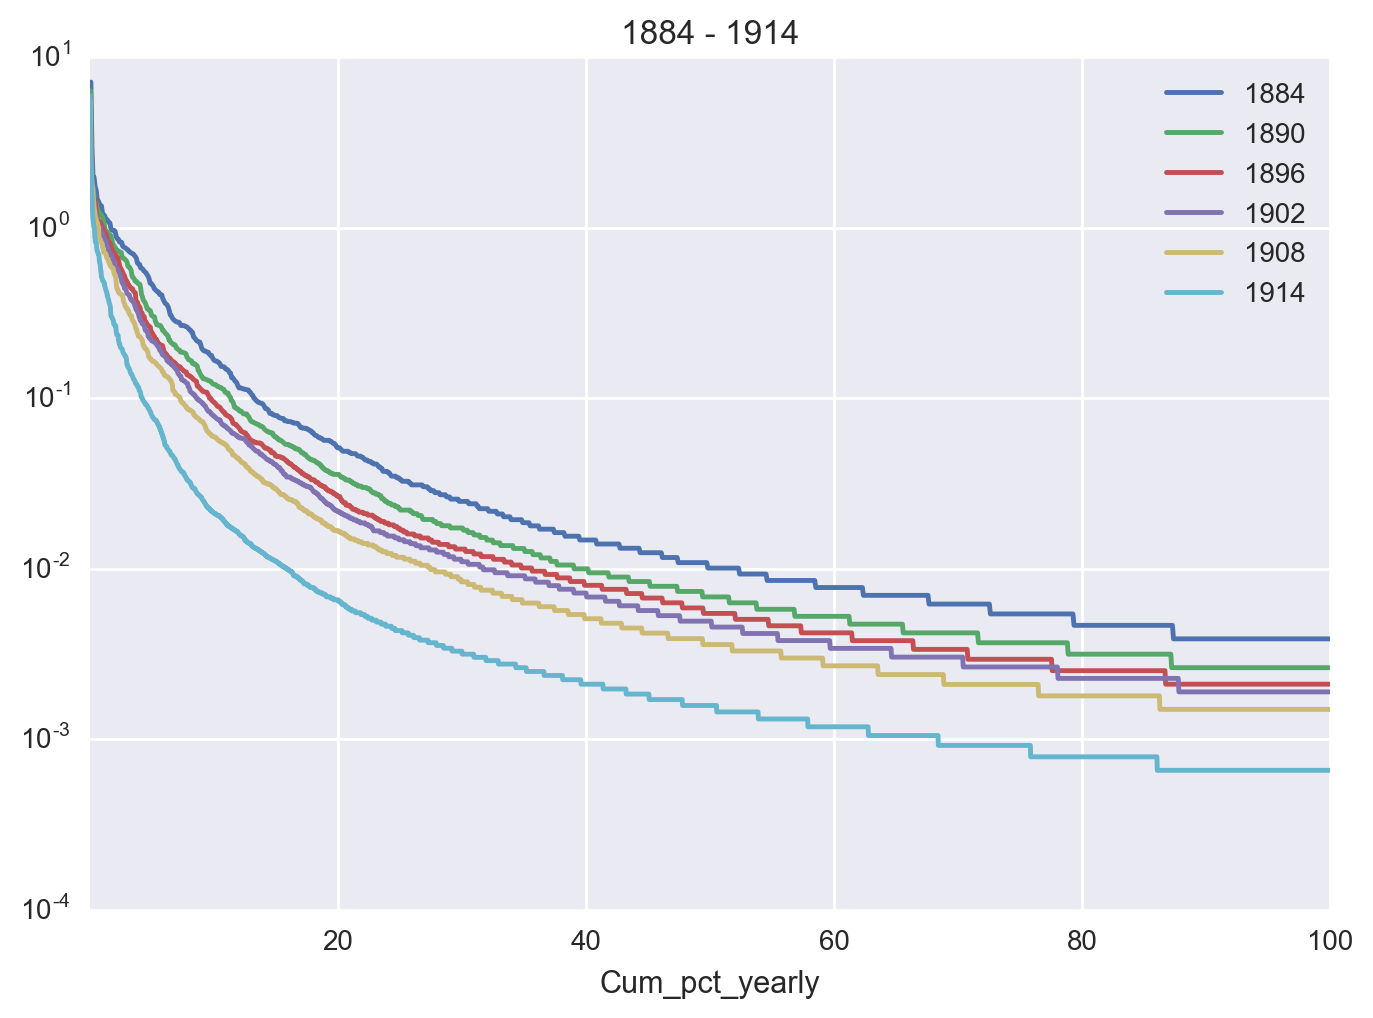

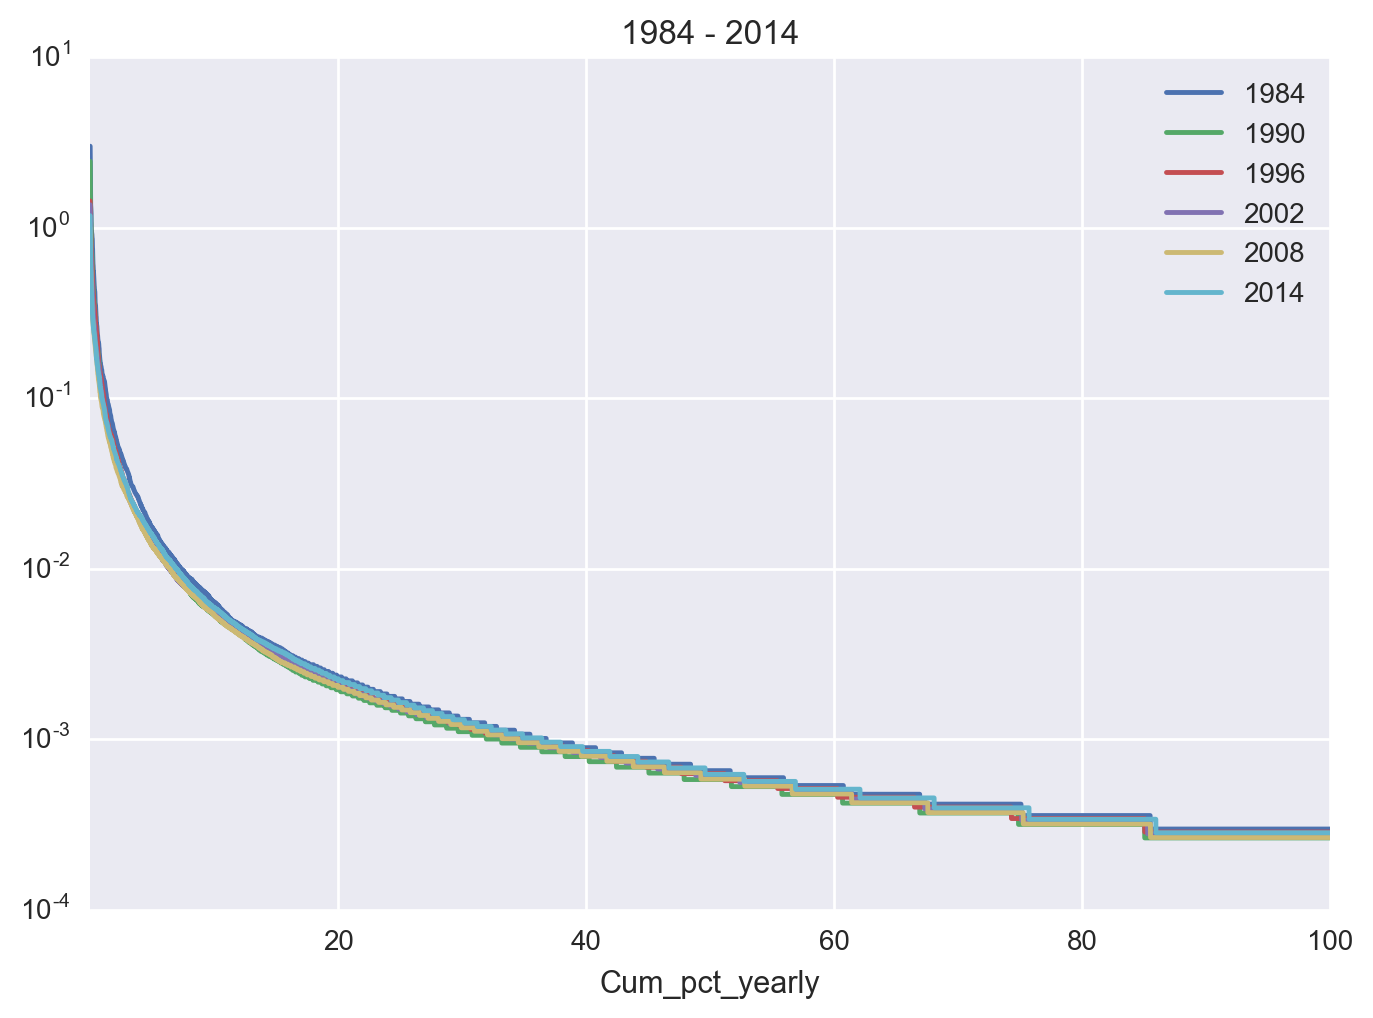

In [11]:
zipf_plotter(1884, 1915, 6, x="Cum_pct_yearly", logx=False)
zipf_plotter(1984, 2015, 6, x="Cum_pct_yearly", logx=False)

## Look at the frequency of most popular names by year

The plot below shows the frequency of the most popular name by year. Based on this plot, one might conclude that American names are becoming less Zipfian. 

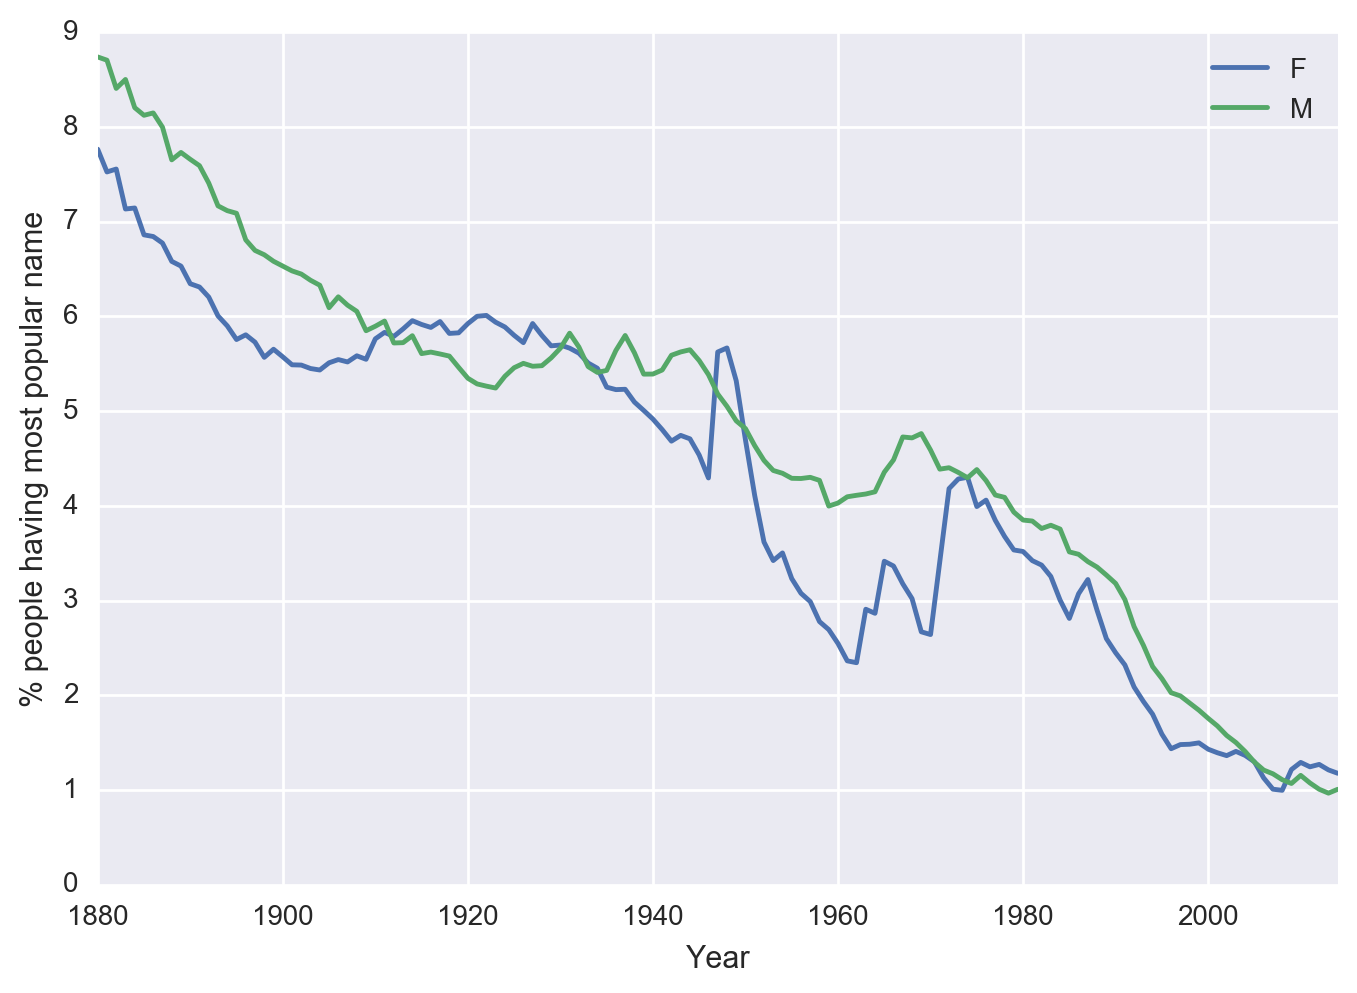

In [15]:
_, ax = plt.subplots(1, 1)
s = gb['Freq_yearly'].max().reset_index()
genders = ['F','M']
for gender in genders:
  s.loc[s.Gender == gender,:].plot.line('Year','Freq_yearly', ax=ax)
  
for t, g in zip(ax.legend().get_texts(), genders):
  t.set_text(g)
  
ax.set_ylabel("% people having most popular name")

### The Linda peak
Why the rise of Linda in the late 1940s?

In [69]:
leaders.reset_index?

In [70]:
postwar_women = df.loc[(df.Year >= 1940) & (df.Year <= 1960) & (df.Gender == "F"), :]
leaders = postwar_women.loc[postwar_women.Rank_yearly == 1.0, ["Year","Name"]].reset_index(drop=True)
lindas = postwar_women.loc[postwar_women.Name == "Linda", ["Year","Rank_yearly"]].reset_index(drop=True)
pd.concat([leaders, lindas.rename_axis({"Rank_yearly":"Linda_rank"}, axis=1)], axis=1)

,Year,Name,Year,Linda_rank
0,1940,Mary,1940,8.0
1,1941,Mary,1941,5.0
2,1942,Mary,1942,4.0
3,1943,Mary,1943,4.0
4,1944,Mary,1944,3.0
5,1945,Mary,1945,2.0
6,1946,Mary,1946,2.0
7,1947,Linda,1947,1.0
8,1948,Linda,1948,1.0
9,1949,Linda,1949,1.0


### Identify the sets of highest ranked names over the years
What a (surprisingly) small list!

In [74]:
df.loc[(df.Rank_yearly == 1),:].groupby(["Gender","Name"]).count()[["Count"]]

Count
Gender Name           
F      Ashley        2
       Emily        12
       Emma          2
       Isabella      2
       Jennifer     15
       Jessica       9
       Linda         6
       Lisa          8
       Mary         76
       Sophia        3
M      David         1
       Jacob        14
       James        13
       John         44
       Michael      44
       Noah          2
       Robert       17

## The 80-20 rule

How many people share the top 20% of all names?

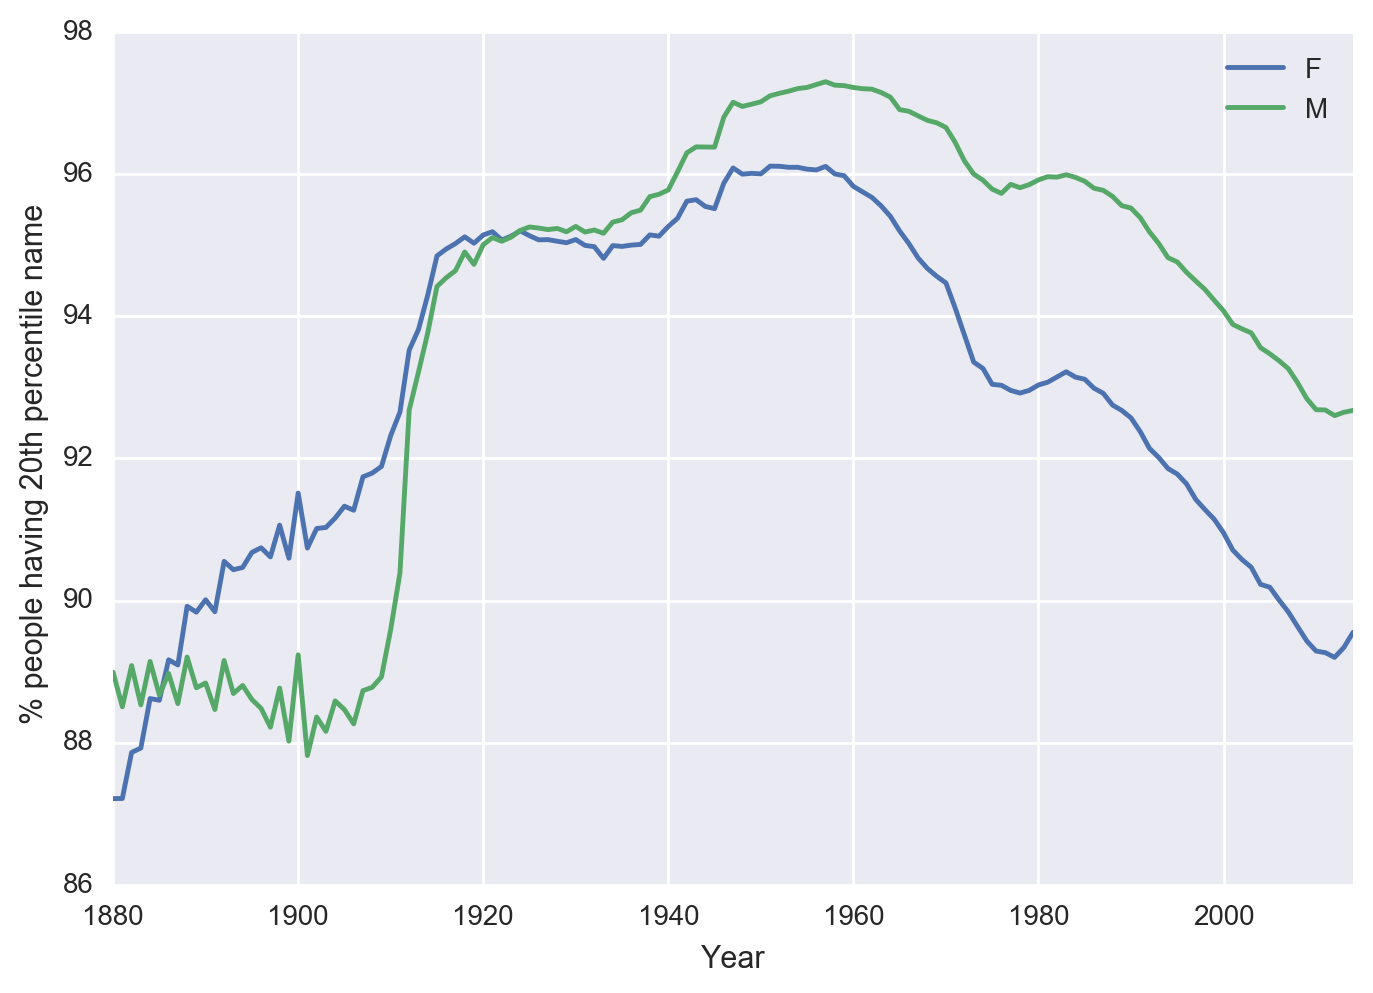

In [13]:
df_top20 = df.loc[df.Cum_pct_yearly <= 20.0, :].groupby(['Year','Gender'], sort=False)['Freq_yearly'].sum().reset_index()
df_top20 = df_top20.rename(columns={'Freq_yearly':'Freq_yearly_top20'})

fig, ax = plt.subplots(1, 1)
for gender in ['F','M']:
  df_top20.loc[df_top20.Gender == gender,:].plot.line('Year','Freq_yearly_top20', ax=ax)
  
for x, s in zip(ax.legend().get_texts(), ['F', 'M']):
  x.set_text(s)
  
_ = ax.set_ylabel("% people having 20th percentile name ")

## What is going on?
The shape of the distributions have changed over time. The top X% of names are accounted for by a larger number of names over time.

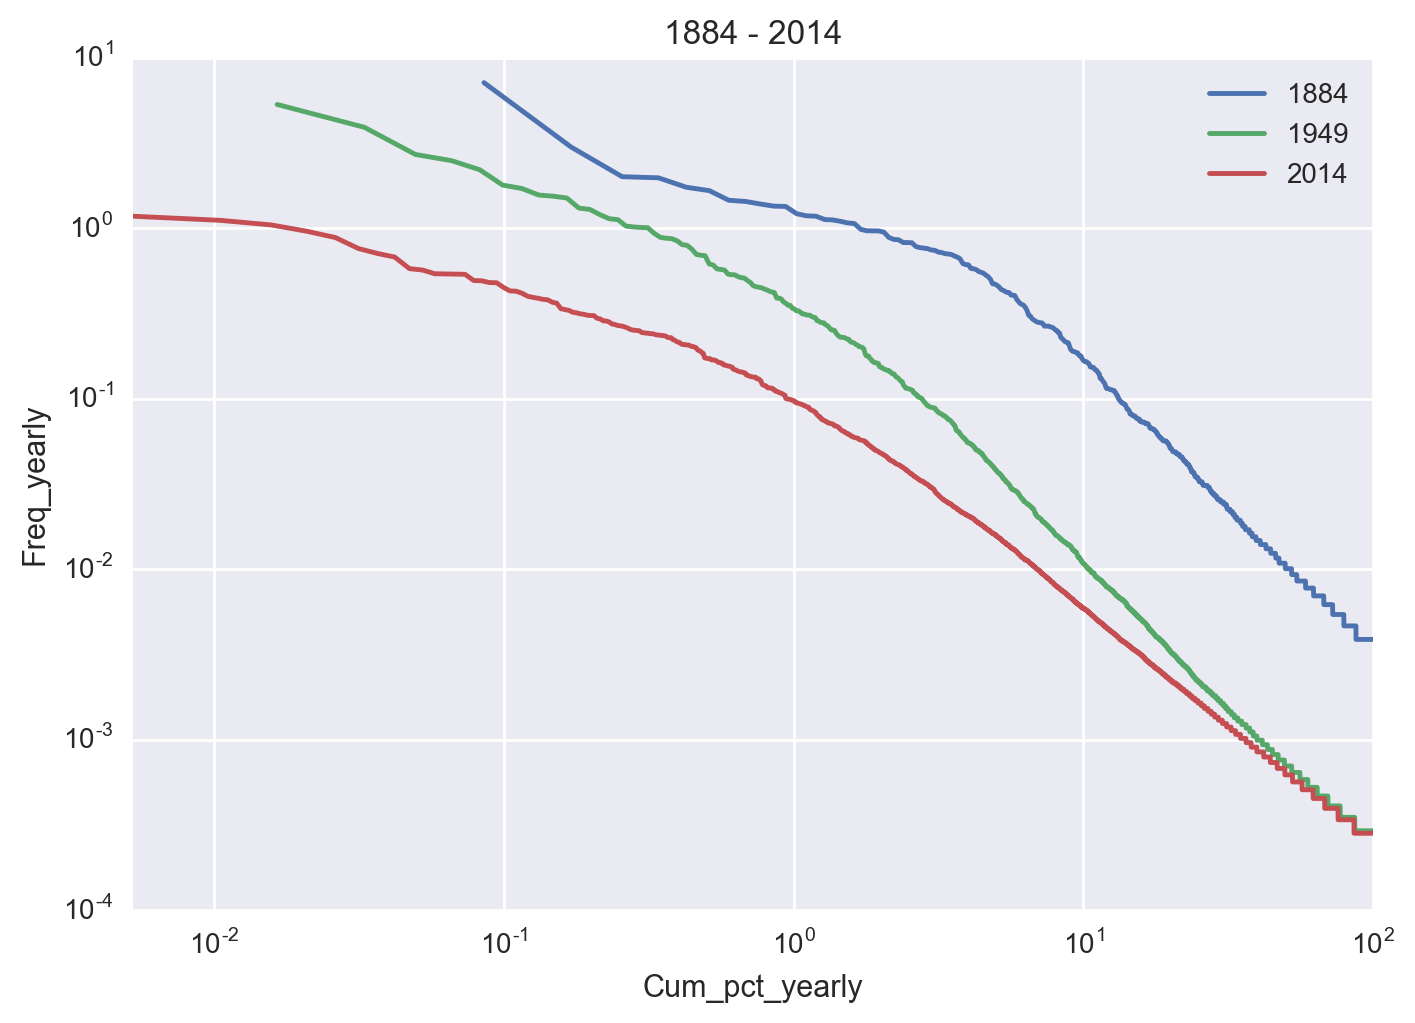

In [79]:
zipf_plotter(1884, 2015, 65, x="Cum_pct_yearly", y="Freq_yearly")

### Number of unique names comprising the top 20% of all names

In [186]:
top_20 = df.loc[df.Cum_pct_yearly <= 20.0, :]

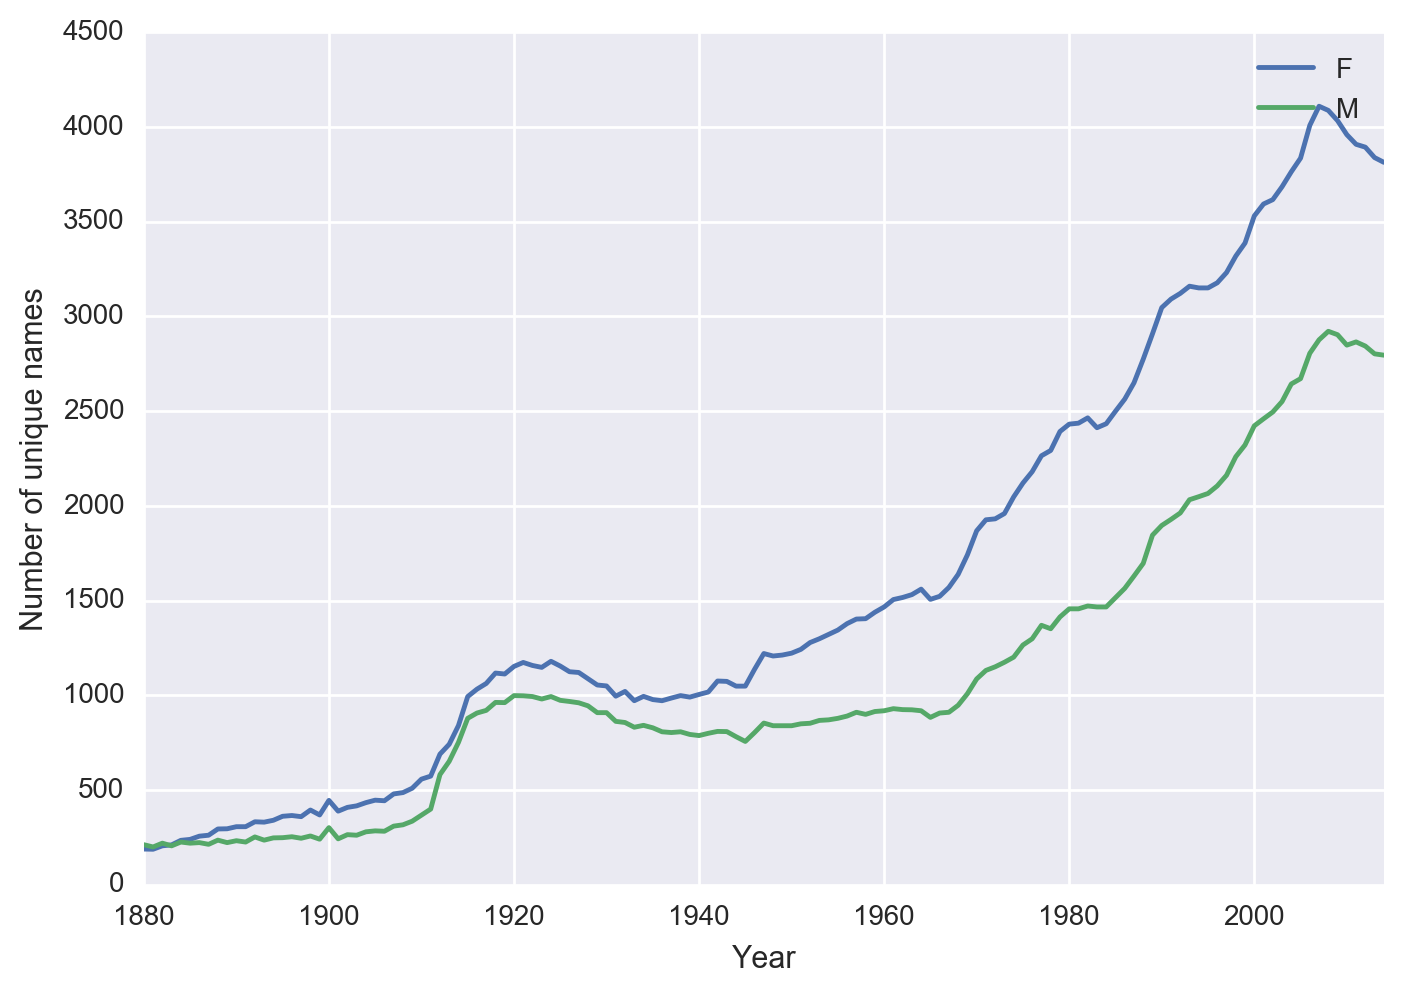

In [114]:
no_in_top_20 = top_20.groupby(["Gender","Year"]).count()[["Count"]]
fig, ax = plt.subplots(1,1)
for g in ['F', 'M']:
  no_in_top_20.loc[g,:].plot(ax=ax)
for x, s in zip(ax.legend().get_texts(), ['F', 'M']):
  x.set_text(s)
ax.set_ylabel("Number of unique names")

### What happens around 1920?
What names were introduced during this time frame?

In [187]:
top_20_1900_to_1940 = top_20.loc[(top_20.Year >= 1900) & (top_20.Year < 1940),:]
name_sets = top_20_1900_to_1940.groupby(["Gender"])["Name"].unique()
  
name_sets.apply(lambda x: len(x))

Gender
F    1607
M    1275
Name: Name, dtype: int64

In [135]:
name_sets

Gender
F    [Mary, Helen, Anna, Margaret, Ruth, Elizabeth,...
M    [John, William, James, George, Charles, Robert...
Name: Name, dtype: object

In [156]:
name_vecs = []
for yr in range(1900,1940):
  name_vec = top_20_1900_to_1940.loc[top_20_1900_to_1940.Gender == "M",:]\
    .groupby(["Name"])["Year"]\
    .aggregate(lambda years: yr in years.values)\
    .as_matrix()
  name_vecs.append(name_vec)

This plot demonstrates that around 1915, many names just "show up" in the top 20%.

[]

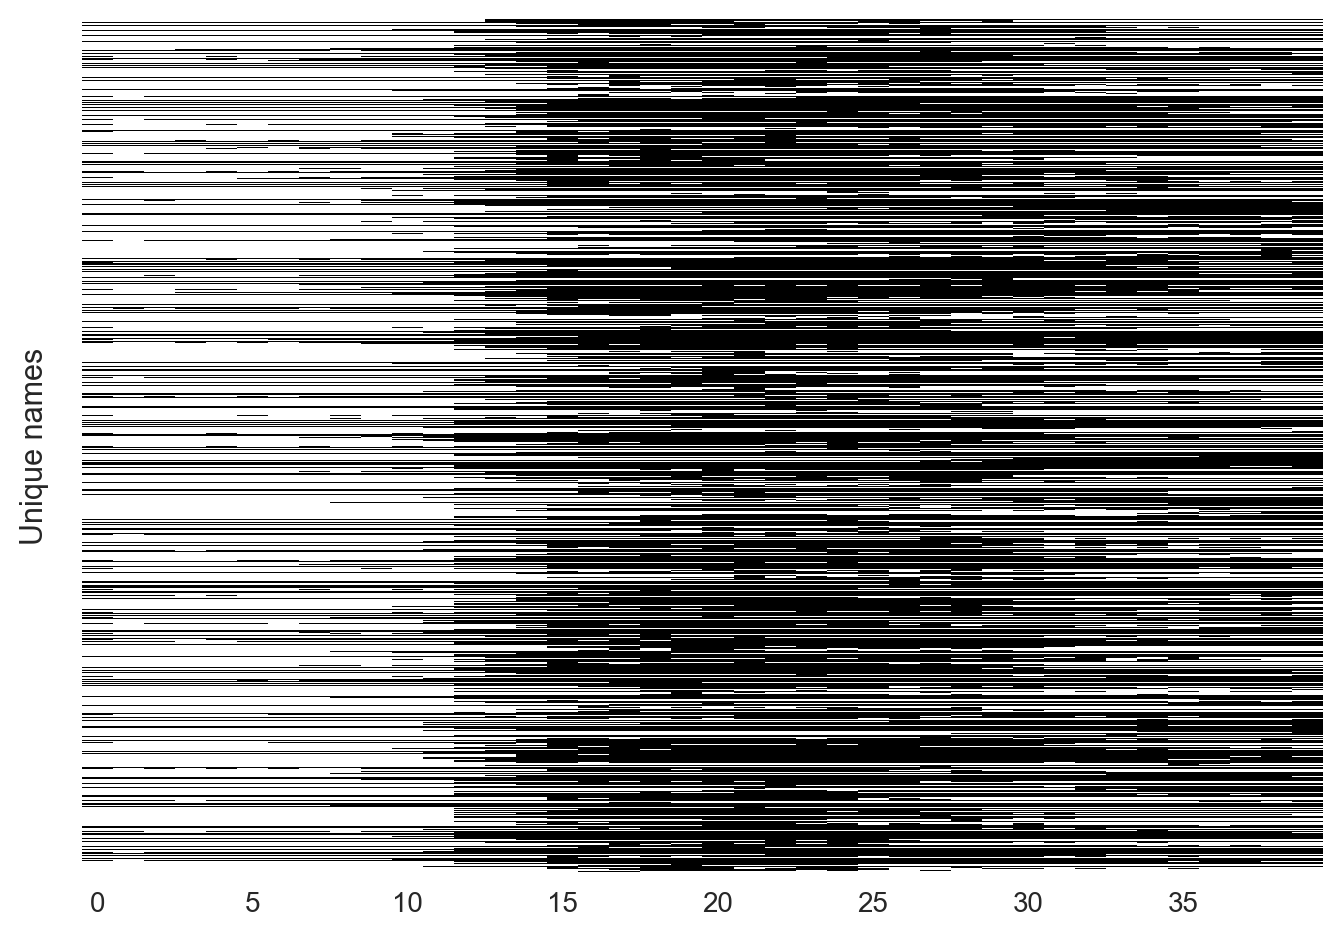

In [171]:
fig, ax = plt.subplots(1,1)
ax.grid()
ax.imshow(np.column_stack(name_vecs), interpolation='nearest', aspect="auto")
ax.set_ylabel("Unique names")
ax.set_yticklabels([])

In [197]:
foo = top_20_1900_to_1940.loc[:,["Name","Year","Cum_freq_yearly"]]
foo["Year_and_Freq"] = foo.apply(lambda row: {row.Year: row.Cum_freq_yearly}, axis=1)

In [198]:
foo["Name","Year_and_Freq"].groupby(["Name"]).aggregate(lambda s: )

,Name,Year,Cum_freq_yearly,Year_and_Freq
52265,Mary,1900,5.572195,{1900: 5.5721947249756525}
52266,Helen,1900,7.687741,{1900: 7.687740971490321}
52267,Anna,1900,9.726910,{1900: 9.726910095121202}
52268,Margaret,1900,11.496591,{1900: 11.496591379057325}
52269,Ruth,1900,13.085836,{1900: 13.085835879237427}
52270,Elizabeth,1900,14.451952,{1900: 14.451952452739569}
52271,Florence,1900,15.759369,{1900: 15.75936870472404}
52272,Ethel,1900,17.058780,{1900: 17.058780367410648}
52273,Marie,1900,18.344851,{1900: 18.34485104793415}
52274,Lillian,1900,19.483504,{1900: 19.483503875555318}


In [195]:
gb_name = top_20_1900_to_1940.loc[:,["Name","Year","Cum_freq_yearly"]].groupby(["Name"])
gb_name.aggregate(lambda s: list(zip(s)))

,Year,Cum_freq_yearly
Name,,
Aaron,"[(1900,), (1901,), (1902,), (1903,), (1904,), ...","[(84.2417557592,), (83.9054766087,), (85.17434..."
Abbie,"[(1900,), (1901,), (1902,), (1903,), (1904,), ...","[(88.0721613725,), (88.7256212711,), (88.62036..."
Abe,"[(1900,), (1902,), (1903,), (1904,), (1905,), ...","[(88.3015833992,), (87.8565779926,), (87.15467..."
Abel,"[(1913,), (1914,), (1915,), (1916,), (1917,), ...","[(93.1221308069,), (93.6340227441,), (93.56789..."
Abigail,"[(1939,)]","[(95.0521560066,)]"
Abner,"[(1913,), (1914,), (1915,), (1916,), (1917,), ...","[(91.8053992044,), (91.7026339342,), (92.08593..."
Abraham,"[(1900,), (1901,), (1902,), (1903,), (1904,), ...","[(84.3753114639,), (86.5343614693,), (84.91345..."
Abram,"[(1913,), (1914,), (1915,), (1916,), (1917,), ...","[(92.826749025,), (92.8192228627,), (92.666299..."
Ada,"[(1900,), (1901,), (1902,), (1903,), (1904,), ...","[(60.1995143882,), (57.9294583619,), (60.81180..."


In [176]:
name_vecs = []
for yr in range(1900, 1901):
  name_vec = top_20_1900_to_1940.loc[top_20_1900_to_1940.Gender == "M",:]\
    .groupby(["Name"])["Cum_pct_yearly"]\
    .transform(lambda x: x)\
    .as_matrix()
  name_vecs.append(name_vec)

In [178]:
name_vecs

[array([  0.06640106,   0.13280212,   0.19920319, ...,  19.93950088,
         19.96470885,  19.98991681])]

## Interesting evolutions of names

In [ ]:
def comp_maker(name, gender, name_fun=(lambda x, g: x)):
  return (df.loc[(df.Name == name) & (df.Gender == gender), ["Year", "Freq_yearly"]]
                             .set_index("Year").T.rename(index={"Freq_yearly":name_fun(name, gender)}).copy())


def compare_names(names_genders, name_fun=(lambda x, g: x), logy=False):
  df_cand = pd.DataFrame()
  for name, gender in names_genders:
    df_cand = df_cand.append(comp_maker(name, gender, name_fun))

  ax = df_cand.T.plot.line(logy=logy)
  ax.set_ylabel("Yearly Frequency")
  return ax

In [ ]:
compare_names([("Donald","M"), ("Gary", "M"), ("Hillary", "F"), ("Jill", "F")])

In [ ]:
compare_names([("Hillary", "F"),("Hillary","M")], lambda n,g: "%s: %s" % (n,g), logy=True)

In [ ]:
compare_names([("Donald", "F"),("Donald","M")], lambda n,g: "%s: %s" % (n,g), logy=True)

In [ ]:
names = ["Hillary", "Lindsey", "Leslie", "Stephanie"]
for name in names:
  compare_names([(name, "F"),(name,"M")], lambda n,g: "%s: %s" % (n,g), logy=True)

## Gender-shifting names

In [ ]:
df_mf = df.set_index(["Year","Name"])
df_ratio = df_mf.loc[df_mf.Gender == "F",["Freq_yearly"]].join(df_mf.loc[df_mf.Gender == "M","Freq_yearly"], 
                                                 rsuffix="_M", how="inner")
df_ratio["Ratio"] = df_ratio.Freq_yearly_M / df_ratio.Freq_yearly

df_ratio = df_ratio.reset_index().groupby('Name').filter(lambda x: len(x) > 90)

alpha = 5.0 # how much more prevalent was one name than the other, in terms of frequency
df_ratio = df_ratio.groupby("Name").filter(lambda x: x.Ratio.max() > alpha and x.Ratio.min() < (1/alpha))

df_ratio.groupby("Name").count().count()

In [ ]:
df.plot?

In [ ]:
for n, df_sub in df_ratio.groupby("Name"):
  ax = df_sub.plot.line("Year","Ratio", title=n, logy=True, legend=False, xlim=(1880,2015), ylim=(1e-3,1e2))
  ax.set_ylabel("Ratio of males to females")